# Vision Transformer and Masked Autoencoder

In this assignment, you will be implementing [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) and [Masked Autoencoder (MAE)](https://arxiv.org/abs/2111.06377).

## Setup

We recommend working on Colab with GPU enabled since this assignment needs a fair amount of compute.
In Colab, we can enforce using GPU by clicking `Runtime -> Change Runtime Type -> Hardware accelerator` and selecting `GPU`.
The dependencies will be installed once the notebooks are excuted.

You should make a copy of this notebook to your Google Drive otherwise the outputs will not be saved.
Once the folder is copied, you can start working by clicking a Jupyter Notebook and openning it in Colab.

In [ ]:
!nvidia-smi # Confirm GPU is enabled

In [ ]:
pip -q install einops

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn
seaborn.set()

from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import einops
import pickle
import os

torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Mount drive to save models and logs
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Note**: change ```root_folder``` to the folder of this notebook in your google drive

In [ ]:
root_folder = "/content/drive/MyDrive/cs182_hw4_colab/"
os.makedirs(root_folder, exist_ok=True)
os.chdir(root_folder)

In [ ]:
#@title Download Testing Data
!wget -O '/content/autograder_student.pt' 'https://cs182sp22.github.io/assets/data/autograder_student.pt'
!wget -O '/content/test_reference.pt' 'https://cs182sp22.github.io/assets/data/test_reference.pt'

test_data = torch.load('/content/test_reference.pt')
auto_grader_data = torch.load('/content/autograder_student.pt')
auto_grader_data['output'] = {}

In [ ]:
#@title Utilities for Testing
def save_auto_grader_data():
    torch.save(
        {'output': auto_grader_data['output']},
        'autograder.pt'
    )

def rel_error(x, y):
    return torch.max(
        torch.abs(x - y)
        / (torch.maximum(torch.tensor(1e-8), torch.abs(x) + torch.abs(y)))
    ).item()

def check_error(name, x, y, tol=1e-3):
    error = rel_error(x, y)
    if error > tol:
        print(f'The relative error for {name} is {error}, should be smaller than {tol}')
    else:
        print(f'The relative error for {name} is {error}')

def check_acc(acc, threshold):
    if acc < threshold:
        print(f'The accuracy {acc} should >= threshold accuracy {threshold}')
    else:
        print(f'The accuracy {acc} is better than threshold accuracy {threshold}')

## Vision Transformer
The first part of this notebook is implementing Vision Transformer (ViT) and training it on CIFAR dataset.

### Image patchify and unpatchify

In ViT, an image is split into fixed-size patches, each of them are then linearly embedded, position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder. The architecture can be seen in the following figure.
![vit](https://github.com/google-research/vision_transformer/blob/main/vit_figure.png?raw=true)

To get started with implementing ViT, you need to implement splitting image batch into fixed-size patches batch in ```patchify``` and combining patches batch into the original image batch in ```unpatchify```.

We strongly recommend using [einops](https://github.com/arogozhnikov/einops) for flexible tensor operations, you can check out its [tutorial](https://einops.rocks/1-einops-basics/). 

In [ ]:
from einops import rearrange
def patchify(images, patch_size=4):
    """Splitting images into patches.
    Args:
        images: Input tensor with size (batch, channels, height, width)
            We can assume that image is square where height == width.
    Returns:
        A batch of image patches with size (
          batch, (height / patch_size) * (width / patch_size), 
        channels * patch_size * patch_size)
    """
    # BEGIN YOUR CODE
    return rearrange(images,'b c (h1 h2) (w1 w2) -> b (h1 w1) (c h2 w2)', h2=patch_size, w2=patch_size)
    # END YOUR CODE

def unpatchify(patches, patch_size=4):
    """Combining patches into images.
    Args:
        patches: Input tensor with size (
        batch, (height / patch_size) * (width / patch_size), 
        channels * patch_size * patch_size)
    Returns:
        A batch of images with size (batch, channels, height, width)
    """
    # BEGIN YOUR CODE
    b,s1,s2=patches.shape
    h1=int(np.sqrt(s1))
    return rearrange(patches,'b (h1 h2) (c h3 h4) -> b c (h1 h3) (h2 h4)', h1=h1, h2=h1, h3=patch_size, h4=patch_size)
    # END YOUR CODE

In [ ]:
#@title Test your implementation
x = test_data['input']['patchify']
y = test_data['output']['patchify']
check_error('patchify', patchify(x), y)

x = auto_grader_data['input']['patchify']
auto_grader_data['output']['patchify'] = patchify(x)
save_auto_grader_data()


x = test_data['input']['unpatchify']
y = test_data['output']['unpatchify']
check_error('unpatchify', unpatchify(x), y)

x = auto_grader_data['input']['unpatchify']
auto_grader_data['output']['unpatchify'] = unpatchify(x)

save_auto_grader_data()

The relative error for patchify is 0.0
The relative error for unpatchify is 0.0


### ViT model
You need to use the given Transformer encoder ```Transformer``` to implement ViT in ```ViT``` and ```ClassificationViT```.

In [ ]:
class Transformer(nn.Module):
    """Transformer Encoder 
    Args:
        embedding_dim: dimension of embedding
        n_heads: number of attention heads
        n_layers: number of attention layers
        feedforward_dim: hidden dimension of MLP layer
    Returns:
        Transformer embedding of input
    """
    def __init__(self, embedding_dim=256, n_heads=4, n_layers=4, feedforward_dim=1024):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.feedforward_dim = feedforward_dim
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embedding_dim,
                nhead=self.n_heads,
                dim_feedforward=self.feedforward_dim,
                activation=F.gelu,
                batch_first=True,
                dropout=0.0,
            ),
            num_layers=n_layers,
        )

    def forward(self, x):
        return self.transformer(x)

class ClassificationViT(nn.Module):
    """Vision transformer for classfication
    Args:
        n_classes: number of classes 
        embedding_dim: dimension of embedding
        patch_size: image patch size
        num_patches: number of image patches
    Returns:
        Logits of classfication
    """
    def __init__(self, n_classes, embedding_dim=256, patch_size=4, num_patches=8):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.embedding_dim = embedding_dim

        self.transformer = Transformer(embedding_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim) * 0.02)
        self.position_encoding = nn.Parameter(
            torch.randn(1, num_patches * num_patches + 1, embedding_dim) * 0.02
        )
        self.patch_projection = nn.Linear(patch_size * patch_size * 3, embedding_dim)
        
        # A Layernorm and a Linear layer are applied on ViT encoder embeddings
        self.output_head = nn.Sequential(
            nn.LayerNorm(embedding_dim), nn.Linear(embedding_dim, n_classes)
        )

    def forward(self, images):
        """ 
        (1) Splitting images into fixed-size patches; 
        (2) Linearly embed each image patch, append CLS token; 
        (3) Add position embeddings;
        (4) Feed the resulting sequence of vectors to Transformer encoder.
        (5) Extract the embeddings corresponding to the CLS token.
        (6) Apply output head to the embeddings to obtain the logits
        """
        # BEGIN YOUR CODE
        image_patches=patchify(images, patch_size=self.patch_size)
        image_patches = self.patch_projection(image_patches)
        image_patches = torch.cat((self.cls_token.expand([images.shape[0], -1, -1]),image_patches),dim=1)
        image_patches = image_patches + self.position_encoding
        out = self.transformer(image_patches)
        out = out[:,0,:]
        return self.output_head(out)
        # END YOUR CODE


In [ ]:
#@title Test your implementation
model = ClassificationViT(10)
model.load_state_dict(test_data['weights']['ClassificationViT'])
x = test_data['input']['ClassificationViT.forward']
y = model.forward(x)
check_error('ClassificationViT.forward', y, test_data['output']['ClassificationViT.forward'])

model.load_state_dict(auto_grader_data['weights']['ClassificationViT'])
x = auto_grader_data['input']['ClassificationViT.forward']
y = model.forward(x)
auto_grader_data['output']['ClassificationViT.forward'] = y
save_auto_grader_data()

The relative error for ClassificationViT.forward is 0.0


### Data Loader and Preprocess

We use ```torchvision``` to download and prepare images and labels.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='/content/data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/content/data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/data/cifar-10-python.tar.gz to /content/data
Files already downloaded and verified


### Supervised Training ViT 



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Val Accuracy')

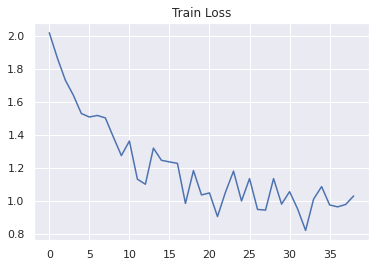

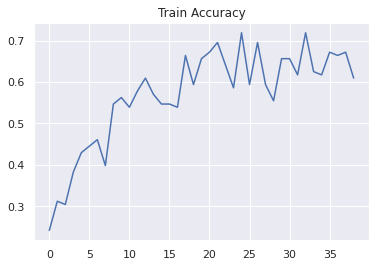

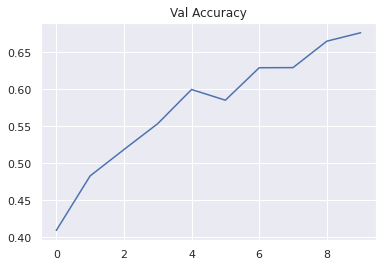

In [ ]:
# Initilize model (ClassificationViT)
model = ClassificationViT(10)
# Move model to GPU 
model.to(torch_device)
# Create optimizer for the model

# You may want to tune these hyperparameters to get better performance
optimizer = optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.95), weight_decay=1e-9)

total_steps = 0
num_epochs = 10
train_logfreq = 100
losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x, y = x.to(torch_device), y.to(torch_device)
        logits = model(x)
        loss = torch.mean(F.cross_entropy(logits, y))
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item(), train_acc=accuracy.item())

        if total_steps % train_logfreq == 0:
            losses.append(loss.item())
            train_acc.append(accuracy.item())

    # Validation
    val_acc = []
    model.eval()
    for x, y in testloader:
        x, y = x.to(torch_device), y.to(torch_device)
        with torch.no_grad():
          logits = model(x)
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        val_acc.append(accuracy.item())
    model.train()

    all_val_acc.append(np.mean(val_acc))
    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

plt.plot(losses)
plt.title('Train Loss')
plt.figure()
plt.plot(train_acc)
plt.title('Train Accuracy')
plt.figure()
plt.plot(all_val_acc)
plt.title('Val Accuracy')

In [ ]:
#@title Test your implementation, your accuracy should be greater than 65%
auto_grader_data['output']['vit_acc'] = best_val_acc
save_auto_grader_data()
check_acc(best_val_acc, threshold=0.65)

The accuracy 0.6764240506329114 is better than threshold accuracy 0.65


## Masked AutoEncoder

The second part of this notebook is implementing Masked Autoencoder (MAE).
The idea of MAE is masking random patches of the input image and reconstruct the missing pixels. This whole achitecture can be seen in the following figure.
![mae](https://user-images.githubusercontent.com/11435359/146857310-f258c86c-fde6-48e8-9cee-badd2b21bd2c.png)

You will train MAE without labels on CIFAR, aka, self-supervised learning.
Then you will use the self-supervised pretrained model for linear classification and finetuning experiments.

### Random Masking and Restore

To get started with MAE, you need to implement ```random_masking``` to mask random patches from the input image and ```restore_masked``` to combine reconstructed masked part and unmasked part to restore the image.

In [ ]:
def index_sequence(x, ids):
    """Index tensor (x) with indices given by ids
    Args:
        x: input sequence tensor, can be 2D (batch x length) or 3D (batch x length x feature)
        ids: 2D indices (batch x length) for re-indexing the sequence tensor
    """
    if len(x.shape) == 3:
        ids = ids.unsqueeze(-1).expand(-1, -1, x.shape[-1])
    return torch.take_along_dim(x, ids, dim=1)

def random_masking(x, keep_length, ids_shuffle):
    """Apply random masking on input tensor
    Args:
        x: input patches (batch x length x feature)
        keep_length: length of unmasked patches
        ids_shuffle: random indices for shuffling the input sequence 
    Returns:
        kept: unmasked part of x
        mask: a 2D (batch x length) mask tensor of 0s and 1s indicated which
            part of x is masked out. The value 0 indicates not masked and 1
            indicates masked.
        ids_restore: indices to restore x. If we take the kept part and masked
            part of x, concatentate them together and index it with ids_restore,
            we should get x back.

    Hint:
        ids_shuffle contains the indices used to shuffle the sequence (patches).
        You should use the provided index_sequence function to re-index the
        sequence, and keep the first keep_length number of patches.
    """
    # BEGIN YOUR CODE
    N, L, D = x.shape
    kept = index_sequence(x, ids_shuffle)[:,:keep_length,:]
    mask = torch.ones([N, L],device=x.device)
    mask[:,:keep_length] = 0
    ids_restore = torch.argsort(ids_shuffle,dim=1)
    mask = torch.gather(mask,dim=1,index=ids_restore)
    return kept,mask,ids_restore
    # END YOUR CODE

def restore_masked(kept_x, masked_x, ids_restore):
    """Restore masked patches
    Args:
        kept_x: unmasked patches
        masked_x: masked patches
        ids_restore: indices to restore x
    Returns:
        restored patches
    """
    # BEGIN YOUR CODE
    restore_x = torch.cat([kept_x,masked_x], dim=1)
    restore_x = torch.gather(restore_x,dim=1,index=ids_restore.unsqueeze(-1).expand(-1,-1,kept_x.shape[-1]))
    return restore_x
    # END YOUR CODE

In [ ]:
#@title Test your implementation
x, ids_shuffle = test_data['input']['random_masking']
kept, mask, ids_restore = random_masking(x, 4, ids_shuffle)
kept_t, mask_t, ids_restore_t = test_data['output']['random_masking']
check_error('random_masking: kept', kept, kept_t)
check_error('random_masking: mask', mask, mask_t)
check_error('random_masking: ids_restore', ids_restore, ids_restore_t)

x, ids_shuffle = auto_grader_data['input']['random_masking']
kept, mask, ids_restore = random_masking(x, 4, ids_shuffle)
auto_grader_data['output']['random_masking'] = (kept, mask, ids_restore)
save_auto_grader_data()

kept_x, masked_x, ids_restore = test_data['input']['restore_masked']
restored = restore_masked(kept_x, masked_x, ids_restore)
check_error('restore_masked', restored, test_data['output']['restore_masked'])

kept_x, masked_x, ids_restore = auto_grader_data['input']['restore_masked']
restored = restore_masked(kept_x, masked_x, ids_restore)
auto_grader_data['output']['restore_masked'] = (kept, mask, ids_restore)
save_auto_grader_data()

The relative error for random_masking: kept is 0.0
The relative error for random_masking: mask is 0.0
The relative error for random_masking: ids_restore is 0.0
The relative error for restore_masked is 0.0


In [ ]:
class MaskedAutoEncoder(nn.Module):
    """MAE Encoder
    Args:
        encoder: vit encoder
        decoder: vit decoder
        encoder_embedding_dim: embedding size of encoder
        decoder_embedding_dim: embedding size of decoder
        patch_size: image patch size
        num_patches: number of patches
        mask_ratio: percentage of masked patches
    """
    def __init__(self, encoder, decoder, encoder_embedding_dim=256, 
                 decoder_embedding_dim=128, patch_size=4, num_patches=8,
                 mask_ratio=0.75):
        super().__init__()
        self.encoder_embedding_dim = encoder_embedding_dim
        self.decoder_embedding_dim = decoder_embedding_dim
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.mask_ratio = mask_ratio

        self.masked_length = int(num_patches * num_patches * mask_ratio)
        self.keep_length = num_patches * num_patches - self.masked_length

        self.encoder = encoder
        self.decoder = decoder

        self.encoder_input_projection = nn.Linear(patch_size * patch_size * 3, encoder_embedding_dim)
        self.decoder_input_projection = nn.Linear(encoder_embedding_dim, decoder_embedding_dim)
        self.decoder_output_projection = nn.Linear(decoder_embedding_dim, patch_size * patch_size * 3)
        self.cls_token = nn.Parameter(torch.randn(1, 1, encoder_embedding_dim) * 0.02)
        self.encoder_position_encoding = nn.Parameter(torch.randn(1, num_patches * num_patches, encoder_embedding_dim) * 0.02)
        self.decoder_position_encoding = nn.Parameter(torch.randn(1, num_patches * num_patches, decoder_embedding_dim) * 0.02)
        self.masked_tokens = nn.Parameter(torch.randn(1, 1, decoder_embedding_dim) * 0.02)

    def forward_encoder(self, images, ids_shuffle=None):
        """Encode input images
        You should implement the following steps
        (1) patchify images into patches
        (2) linear projection
        (3) add position encoding
        (4) concatenate cls_token and patches embedding and pass it to vit encoder
        """
        batch_size = images.shape[0]
        # Generate random shuffling indices
        if ids_shuffle is None:
            ids_shuffle = torch.argsort(
                torch.rand(
                    (batch_size, self.num_patches * self.num_patches),
                    device=images.device
                ),
                dim=1
            )
        # BEGIN YOUR CODE
        image_patches=patchify(images, patch_size=self.patch_size)
        image_patches = self.encoder_input_projection(image_patches)
        image_patches = image_patches + self.encoder_position_encoding
        image_patches,mask,ids_restore = random_masking(image_patches,self.keep_length,ids_shuffle)
        image_patches = torch.cat((self.cls_token.expand([batch_size, -1, -1]),image_patches),dim=1)
        out = self.encoder(image_patches)
        return out,mask,ids_restore
        # END YOUR CODE

    def forward_decoder(self, encoder_embeddings, ids_restore):
        """Decode encoder embeddings
        You should implement the following steps
        (1) linear projection of encoder embeddings
        (2) restore sequence from masked_patches and encoder predictions
        (3) add position encoding
        (3) readd/use CLS token and decode using ViT decoder 
        (4) projection to predict image patches
        """
        # BEGIN YOUR CODE
        en_pred = self.decoder_input_projection(encoder_embeddings)
        mask_tokens = self.masked_tokens.repeat(en_pred.shape[0],ids_restore.shape[1]+1-en_pred.shape[1],1)
        pred = torch.cat([en_pred[:,1:,:], mask_tokens],dim=1)        
        pred = torch.gather(pred,dim=1,index=ids_restore.unsqueeze(-1).repeat(1,1,en_pred.shape[2]))
        pred = pred + self.decoder_position_encoding
        pred = torch.cat([en_pred[:,:1,:],pred], dim=1)
        out = self.decoder_output_projection(self.decoder(pred))
        return out[:,1:,:]
        # END YOUR CODE

    def forward(self, images):
        encoder_output, mask, ids_restore = self.forward_encoder(images)
        decoder_output = self.forward_decoder(encoder_output, ids_restore)
        return decoder_output, mask

    def forward_encoder_representation(self, images):
        """Encode images without applying random masking to get representation
        of input images. 

        You should implement splitting images into patches, readd/use CLS token,
        and encoding with ViT encoder.
        """
        # BEGIN YOUR CODE
        image_patches=patchify(images, patch_size=self.patch_size)
        image_patches = self.encoder_input_projection(image_patches)
        image_patches = image_patches + self.encoder_position_encoding
        image_patches = torch.cat((self.cls_token.expand([images.shape[0], -1, -1]),image_patches),dim=1)
        out = self.encoder(image_patches)
        return out
        # END YOUR CODE
        

In [ ]:
#@title Test your implementation
model = MaskedAutoEncoder(
    Transformer(embedding_dim=256, n_layers=4),
    Transformer(embedding_dim=128, n_layers=2),
)

model.load_state_dict(test_data['weights']['MaskedAutoEncoder'])
images, ids_shuffle = test_data['input']['MaskedAutoEncoder.forward_encoder']
encoder_embeddings_t, mask_t, ids_restore_t = test_data['output']['MaskedAutoEncoder.forward_encoder']
encoder_embeddings, mask, ids_restore = model.forward_encoder(
    images, ids_shuffle
)

check_error(
    'MaskedAutoEncoder.forward_encoder: encoder_embeddings',
    encoder_embeddings, encoder_embeddings_t
)
check_error(
    'MaskedAutoEncoder.forward_encoder: mask',
    mask, mask_t
)
check_error(
    'MaskedAutoEncoder.forward_encoder: ids_restore',
    ids_restore, ids_restore_t
)

encoder_embeddings, ids_restore = test_data['input']['MaskedAutoEncoder.forward_decoder']
decoder_output_t = test_data['output']['MaskedAutoEncoder.forward_decoder']
decoder_output = model.forward_decoder(encoder_embeddings, ids_restore)
check_error(
    'MaskedAutoEncoder.forward_decoder',
    decoder_output,
    decoder_output_t
)

images = test_data['input']['MaskedAutoEncoder.forward_encoder_representation']
encoder_representations_t = test_data['output']['MaskedAutoEncoder.forward_encoder_representation']
encoder_representations = model.forward_encoder_representation(images)
check_error(
    'MaskedAutoEncoder.forward_encoder_representation',
    encoder_representations,
    encoder_representations_t
)



model = MaskedAutoEncoder(
    Transformer(embedding_dim=256, n_layers=4),
    Transformer(embedding_dim=128, n_layers=2),
)

model.load_state_dict(auto_grader_data['weights']['MaskedAutoEncoder'])
images, ids_shuffle = auto_grader_data['input']['MaskedAutoEncoder.forward_encoder']
auto_grader_data['output']['MaskedAutoEncoder.forward_encoder'] = model.forward_encoder(
    images, ids_shuffle
)

encoder_embeddings, ids_restore = auto_grader_data['input']['MaskedAutoEncoder.forward_decoder']
auto_grader_data['output']['MaskedAutoEncoder.forward_decoder'] = model.forward_decoder(encoder_embeddings, ids_restore)

images = auto_grader_data['input']['MaskedAutoEncoder.forward_encoder_representation']
auto_grader_data['output']['MaskedAutoEncoder.forward_encoder_representation'] = model.forward_encoder_representation(images)
save_auto_grader_data()


The relative error for MaskedAutoEncoder.forward_encoder: encoder_embeddings is 0.0
The relative error for MaskedAutoEncoder.forward_encoder: mask is 0.0
The relative error for MaskedAutoEncoder.forward_encoder: ids_restore is 0.0
The relative error for MaskedAutoEncoder.forward_decoder is 2.8008033041260205e-05
The relative error for MaskedAutoEncoder.forward_encoder_representation is 0.0


### Train Masked Autoencoder

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Text(0.5, 1.0, 'MAE Train Loss')

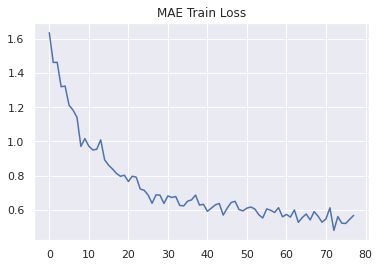

In [ ]:
# Initilize MAE model
model = MaskedAutoEncoder(
    Transformer(embedding_dim=256, n_layers=4),
    Transformer(embedding_dim=128, n_layers=2),
)
# Move the model to GPU
model.to(torch_device)
# Create optimizer

# You may want to tune these hyperparameters to get better performance
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.95), weight_decay=0.05)

total_steps = 0
num_epochs = 20
train_logfreq = 100

losses = []

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x = x.to(torch_device)
        image_patches = patchify(x)
        predicted_patches, mask = model(x)
        loss = torch.sum(torch.mean(torch.square(image_patches - predicted_patches), dim=-1) * mask) / mask.sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item())
        if total_steps % train_logfreq == 0:
            losses.append(loss.item())

    # Periodically save model
    torch.save(model.state_dict(), os.path.join(root_folder, "mae_pretrained.pt"))

plt.plot(losses)
plt.title('MAE Train Loss')

### Use pretrained MAE model for classification

As ViT has a class token, to adapt to this design, in our MAE pre-training we append an auxiliary dummy token to the encoder input. This token will be treated as the class token for training the classifier in linear probing and fine-tuning.

In [ ]:
class ClassificationMAE(nn.Module):
    """A linear classifier is trained on self-supervised representations learned by MAE. 
    Args:
        n_classes: number of classes
        mae: mae model
        embedding_dim: embedding dimension of mae output
        detach: if True, only the classification head is updated.
    """
    def __init__(self, n_classes, mae, embedding_dim=256, detach=False):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.mae = mae
        self.output_head = nn.Sequential(
            nn.LayerNorm(embedding_dim), nn.Linear(embedding_dim, n_classes)
        )
        """
        When self.detach=True, use linear classification, when self.detach=False,
        use full finetuning.
        """
        self.detach = detach

    def forward(self, images):
        # BEGIN YOUR CODE
        out = self.mae.forward_encoder_representation(images)
        if self.detach:
          out=out.detach()
        out = self.output_head(out[:,0,:])
        return out
        # END YOUR CODE

In [ ]:
#@title Test your implementation
model = ClassificationMAE(
    10,
    MaskedAutoEncoder(
        Transformer(embedding_dim=256, n_layers=4),
        Transformer(embedding_dim=128, n_layers=2),
    )
)

model.load_state_dict(test_data['weights']['ClassificationMAE'])

check_error(
    'ClassificationMAE.forward',
    model(test_data['input']['ClassificationMAE.forward']),
    test_data['output']['ClassificationMAE.forward']
)

model = ClassificationMAE(
    10,
    MaskedAutoEncoder(
        Transformer(embedding_dim=256, n_layers=4),
        Transformer(embedding_dim=128, n_layers=2),
    )
)

model.load_state_dict(auto_grader_data['weights']['ClassificationMAE'])
auto_grader_data['output']['ClassificationMAE.forward'] = model(
    auto_grader_data['input']['ClassificationMAE.forward']
)
save_auto_grader_data()

The relative error for ClassificationMAE.forward is 0.0


### Load the pretrained MAE model

In [ ]:
mae = MaskedAutoEncoder(
    Transformer(embedding_dim=256, n_layers=4),
    Transformer(embedding_dim=128, n_layers=2),
)
mae.load_state_dict(torch.load(os.path.join(root_folder, "mae_pretrained.pt")))

<All keys matched successfully>

### Linear Classification

A linear classifier is trained on self-supervised representations learned by MAE. 

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Linear Classification Val Accuracy')

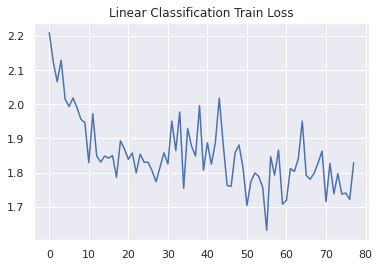

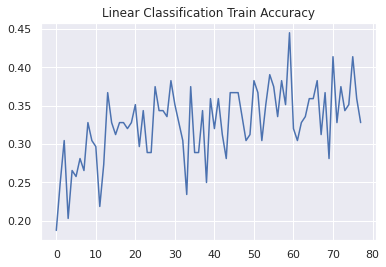

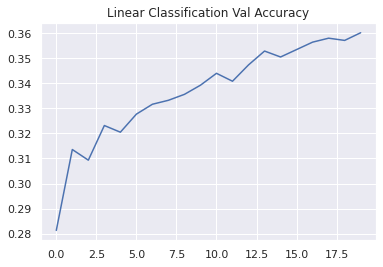

In [ ]:
# Initilize classification model; set detach=True to only update the linear classifier. 
model = ClassificationMAE(10, mae, detach=True)
model.to(torch_device)

# You may want to tune these hyperparameters to get better performance
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.95), weight_decay=1e-9)

total_steps = 0
num_epochs = 20
train_logfreq = 100
losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x, y = x.to(torch_device), y.to(torch_device)
        logits = model(x)
        loss = torch.mean(F.cross_entropy(logits, y))
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item(), train_acc=accuracy.item())

        if total_steps % train_logfreq == 0:
            losses.append(loss.item())
            train_acc.append(accuracy.item())

    # Validation
    val_acc = []
    model.eval()
    for x, y in testloader:
        x, y = x.to(torch_device), y.to(torch_device)
        with torch.no_grad():
          logits = model(x)
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        val_acc.append(accuracy.item())

    model.train()

    all_val_acc.append(np.mean(val_acc))

    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

plt.plot(losses)
plt.title('Linear Classification Train Loss')
plt.figure()
plt.plot(train_acc)
plt.title('Linear Classification Train Accuracy')
plt.figure()
plt.plot(all_val_acc)
plt.title('Linear Classification Val Accuracy')

In [ ]:
#@title Test your implementation, your accuracy should be greater than 30%
auto_grader_data['output']['mae_linear_acc'] = best_val_acc
save_auto_grader_data()
check_acc(best_val_acc, threshold=0.30)

The accuracy 0.3602650316455696 is better than threshold accuracy 0.3


### Full Finetuning

A linear classifer and the pretrained MAE model are jointly updated.

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Finetune Classification Val Accuracy')

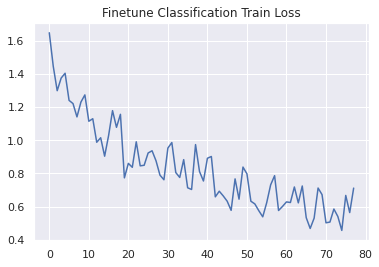

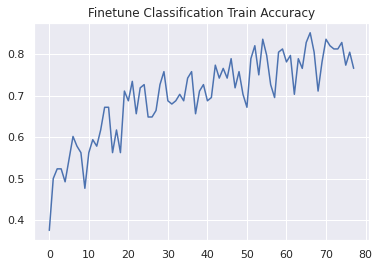

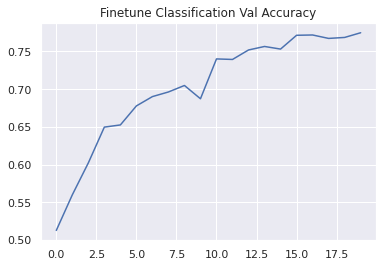

In [ ]:
# Initilize classification model; set detach=False to update both the linear classifier and pretrained MAE model.
model = ClassificationMAE(10, mae, detach=False)
model.to(torch_device)

# You may want to tune these hyperparameters to get better performance
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.95), weight_decay=1e-9)

total_steps = 0
num_epochs = 20
train_logfreq = 100
losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x, y = x.to(torch_device), y.to(torch_device)
        logits = model(x)
        loss = torch.mean(F.cross_entropy(logits, y))
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item(), train_acc=accuracy.item())

        if total_steps % train_logfreq == 0:
            losses.append(loss.item())
            train_acc.append(accuracy.item())

    # Validation
    val_acc = []
    model.eval()
    for x, y in testloader:
        x, y = x.to(torch_device), y.to(torch_device)
        with torch.no_grad():
          logits = model(x)
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        val_acc.append(accuracy.item())
    model.train()

    all_val_acc.append(np.mean(val_acc))

    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

plt.plot(losses)
plt.title('Finetune Classification Train Loss')
plt.figure()
plt.plot(train_acc)
plt.title('Finetune Classification Train Accuracy')
plt.figure()
plt.plot(all_val_acc)
plt.title('Finetune Classification Val Accuracy')

In [ ]:
#@title Test your implementation, your accuracy should be greater than 70%
auto_grader_data['output']['mae_finetune_acc'] = best_val_acc
save_auto_grader_data()
check_acc(best_val_acc, threshold=0.70)

The accuracy 0.7748219936708861 is better than threshold accuracy 0.7


## Prepare Gradescope submission

**NOTE:** change the following path to your ```root_dir``` in the begining.

Run the following cell will automatically prepare and download ```hw4_submission.zip```.

Upload the downloaded file to Gradescope.
The Gradescope will run an autograder on the files you submit. 

It is very unlikely but still possible that your implementation might fail to pass some test cases due to randomness.
If you think your code is correct, you can simply rerun the autograder to check check whether it is really due to randomness.

In [ ]:
%cd /content/drive/MyDrive/cs182_hw4_colab
!pwd # make sure we are in the right dir

!rm hw4_submission.zip
!zip hw4_submission.zip -r *.ipynb autograder.pt

from google.colab import files
files.download('hw4_submission.zip') 

/content
/content/drive/MyDrive/cs182_hw4_colab
rm: cannot remove 'hw4_submission.zip': No such file or directory
	zip warning: name not matched: *.ipynb
  adding: autograder.pt (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>